## The Problem: Large Movie Dataset Review
### Classify movie reviews from IMDB into positive or negative sentiment.
### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [1]:
!pip install gensim tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

2025-02-03 08:32:06.957450: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 08:32:07.723976: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 08:32:08.076390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738571528.668707    1755 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738571528.762698    1755 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 08:32:09.150965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Exploring the data

In [3]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('../../Distributional_Semantics_Code_Files/aclImdb/train')
test_ds = text_dataset_from_directory('../../Distributional_Semantics_Code_Files/aclImdb/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 75000 files belonging to 3 classes.


2025-02-03 08:32:15.754571: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 25000 files belonging to 2 classes.


2025-02-03 08:32:53.551155: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-03 08:33:02.268350: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
pd.options.display.max_colwidth = 200
dfTrain.sample(n=5)

,text,label
62625,Some of the comments left by people on here show just how clueless movie goers can be. As if you can't tell that there's a slight tongue-in-cheek feel to the movie. Doesn't the stupidly high kill ...,2
26511,"...at least during its first half. If it had started out with the three buddies in the navy and concentrated on the naval action scenes, it would have been a much better and tighter film. The seco...",0
14758,"Recap: Full moon. A creature, a huge werewolf, is on the hunt. Not for flesh, not for blood (not that it seem to mind to take a bite on the way though), but for a mate. He is on the hunt for a gir...",0
58780,This is one of the first 'surreal' films that I have seen. Phantom of Liberty for the most part is quite a normal film with a structured narrative and some quite well defined characters What makes...,2
53888,"It's nothing new, genre-bending. Some of the better examples might be movies like THE FIGHTING FISTS OF SHANGHAI JOE, an Italian western with a Chinese star (Chen Lee) that may or may not have bee...",2


In [5]:
print(dfTrain.loc[0, 'text'])

This movie will only appeal to five year old's. It is so lame, and completely dated by now, that it can only be seen as a historical document. The sound effects are so over used, you will scream 'shut up!' at it. Serious needs to go to comedy school for a couple of years, for he needs to learn that a lizard that makes a dinosaur noise isn't funny, and that being literally kicked out of somewhere and accompanied by a voice saying "and stay out!" isn't funny. There have been a lot of great Australian films, and this isn't one of them. I kind of feel a bit sorry for Yahoo Serious, I mean, anyone will a name like that has to have issues in the 'being funny' department. 3/10.


## Tokenize the text

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 153845 unique tokens.


In [7]:
print(train_sequences[0])

[11, 17, 82, 62, 1355, 5, 738, 300, 19264, 9, 6, 36, 840, 2, 334, 1910, 31, 146, 12, 9, 66, 62, 26, 110, 14, 3, 1308, 6438, 1, 497, 286, 23, 36, 119, 327, 22, 82, 2128, 40751, 53, 833, 30, 9, 625, 784, 5, 138, 5, 201, 380, 16, 3, 365, 4, 151, 16, 28, 784, 5, 859, 12, 3, 8644, 12, 159, 3, 4619, 3755, 215, 152, 2, 12, 107, 1204, 4199, 42, 4, 1282, 2, 4432, 31, 3, 570, 673, 2, 782, 42, 215, 152, 47, 25, 75, 3, 169, 4, 80, 2680, 103, 2, 11, 215, 27, 4, 90, 10, 244, 4, 232, 3, 222, 771, 16, 13452, 625, 10, 381, 258, 82, 3, 394, 37, 12, 44, 5, 25, 1218, 8, 1, 36293, 30442, 2530, 317, 162]


In [8]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

['this', 'movie', 'will', 'only', 'appeal', 'to', 'five', 'year', "old's", 'it', 'is', 'so', 'lame', 'and', 'completely', 'dated', 'by', 'now', 'that', 'it', 'can', 'only', 'be', 'seen', 'as', 'a', 'historical', 'document', 'the', 'sound', 'effects', 'are', 'so', 'over', 'used', 'you', 'will', 'scream', "'shut", 'up', "'", 'at', 'it', 'serious', 'needs', 'to', 'go', 'to', 'comedy', 'school', 'for', 'a', 'couple', 'of', 'years', 'for', 'he', 'needs', 'to', 'learn', 'that', 'a', 'lizard', 'that', 'makes', 'a', 'dinosaur', 'noise', "isn't", 'funny', 'and', 'that', 'being', 'literally', 'kicked', 'out', 'of', 'somewhere', 'and', 'accompanied', 'by', 'a', 'voice', 'saying', 'and', 'stay', 'out', "isn't", 'funny', 'there', 'have', 'been', 'a', 'lot', 'of', 'great', 'australian', 'films', 'and', 'this', "isn't", 'one', 'of', 'them', 'i', 'kind', 'of', 'feel', 'a', 'bit', 'sorry', 'for', 'yahoo', 'serious', 'i', 'mean', 'anyone', 'will', 'a', 'name', 'like', 'that', 'has', 'to', 'have', 'issue

In [9]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [10]:
MAX_SEQUENCE_LENGTH

2493

In [11]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [12]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

# Train a classifier with Word Embeddings

In [13]:
countries_wiki = KeyedVectors.load('wiki-countries.w2v')

In [14]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-02-03 08:33:22.968193: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.
2025-02-03 08:33:23.072983: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.
2025-02-03 08:33:23.108302: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.
2025-02-03 08:33:23.361000: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.


In [15]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30
)

Epoch 1/30


2025-02-03 08:33:23.908889: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 747900000 exceeds 10% of free system memory.


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.1668 - loss: -3346.0464 - val_accuracy: 0.5000 - val_loss: 53951.6211
Epoch 2/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.1659 - loss: -109332.4453 - val_accuracy: 0.5000 - val_loss: 367279.4375
Epoch 3/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.1673 - loss: -511891.1562 - val_accuracy: 0.5000 - val_loss: 1059072.7500
Epoch 4/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.1658 - loss: -1318992.7500 - val_accuracy: 0.5000 - val_loss: 2191290.0000
Epoch 5/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.1671 - loss: -2575749.0000 - val_accuracy: 0.5000 - val_loss: 3820994.0000
Epoch 6/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.1645 - loss: -4316867.5000 - val_accuracy: 0.5000 - val_loss: 5998552.0000
Epoch 7/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.1674 - loss: -6631130.5000 - val_accuracy: 0.5000 - val_loss: 8779261.0000
Epoc

# Train with a different set of word embeddings

## GloVe: Global Vectors for Word Representation
### Download [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [16]:
glove_wiki = KeyedVectors.load_word2vec_format('../../glove.6B.100d.txt', binary=False, no_header=True)

In [17]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])



In [18]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=32, epochs=6
)


Epoch 1/6
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1667 - loss: -14169.3438 - val_accuracy: 0.5000 - val_loss: 194706.0469
Epoch 2/6
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.1698 - loss: -372257.6875 - val_accuracy: 0.5000 - val_loss: 1120329.7500
Epoch 3/6
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.1688 - loss: -1532107.0000 - val_accuracy: 0.5000 - val_loss: 3026994.2500
Epoch 4/6
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1677 - loss: -3734037.0000 - val_accuracy: 0.5000 - val_loss: 6120468.5000
Epoch 5/6
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1670 - loss: -7218835.5000 - val_accuracy: 0.5000 - val_loss: 10607828.0000
Epoch 6/6
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.1682 - loss: -12165500.0000 - val_accuracy: 0.5000 - val_loss: 16718429.0000


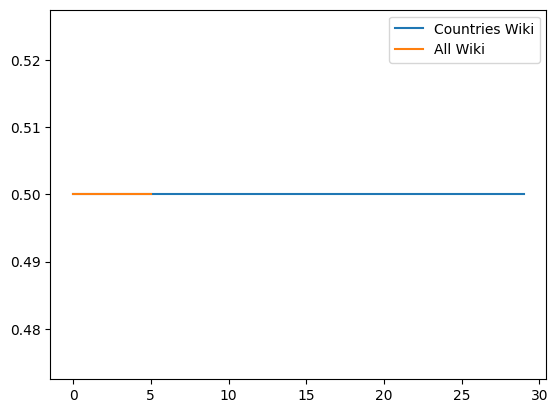

In [19]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All Wiki')
plt.legend()
